# Model Diagnostics

In this section, we introduce to a few recommended diagnostic plots to diagnostic Orbit models. The  posterior samples in **SVI** and **Full Bayesian** i.e. `FullBayesianForecaster` and `SVIForecaster`.

The plots are created by [arviz](https://arviz-devs.github.io/arviz/index.html) for the plots. **ArviZ** is a Python package for exploratory analysis of Bayesian models, includes functions for posterior analysis, data storage, model checking, comparison and diagnostics.

- Trace plot
- Pair plot
- Density plot

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns


%matplotlib inline

import orbit
from orbit.models import LGT, DLT
from orbit.utils.dataset import load_iclaims

import warnings
warnings.filterwarnings('ignore')

from orbit.diagnostics.plot import params_comparison_boxplot
from orbit.constants import palette

In [2]:
print(orbit.__version__)

1.1.3dev


## Load data

In [4]:
df = load_iclaims()
df.dtypes

week              datetime64[ns]
claims                   float64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
sp500                    float64
vix                      float64
dtype: object

In [5]:
df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
1,2010-01-10,13.624218,0.219882,-0.194838,0.168794,-0.425480,0.110445
2,2010-01-17,13.398741,0.236143,-0.292477,0.117500,-0.465229,0.532339
3,2010-01-24,13.137549,0.203353,-0.194838,0.106918,-0.481751,0.428645
4,2010-01-31,13.196760,0.134360,-0.242466,0.074483,-0.488929,0.487404


## Fit a Model

In [6]:
DATE_COL = 'week'
RESPONSE_COL = 'claims'
REGRESSOR_COL = ['trend.unemploy', 'trend.filling', 'trend.job']

In [7]:
dlt = DLT(response_col=RESPONSE_COL,
          date_col=DATE_COL,
          regressor_col=REGRESSOR_COL,
          seasonality=52,
          num_warmup=2000,
          num_sample=2000,
          chains=4)

In [8]:
dlt.fit(df=df)

INFO:orbit:Sampling(PyStan) with chains:4, cores:8, temperature:1.0, warmups(per chain):500 and samples(per chain):500.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


We can use `.get_posterior_samples()` to extract posteriors. Note that we need `permute=False` to retrieve additional information such as chains when we extract posterior samples for posteriors plotting. For regression, in order to collapse and relabel regression from parameters (usually called as `beta`), we use `relabel=True`.  

In [9]:
ps = dlt.get_posterior_samples(relabel=True, permute=False)
ps.keys()

odict_keys(['l', 'b', 'lev_sm', 'slp_sm', 'obs_sigma', 'nu', 'lt_sum', 's', 'sea_sm', 'gt_sum', 'gb', 'gl', 'trend.unemploy', 'trend.filling', 'trend.job'])

## Diagnostics Visualization

In the following section, we are going to use the regression coefficients as an example. In practice, you could check other parameters extracted from the model. For now, it only supports 1-D parameter which in generally capture the most important parameters of the model (e.g. `obs_sigma`, `lev_sm` etc.) 

### Convergence Status

Trace plots help us verify the convergence of model. In general, a largely overlapped distribution across samples from different chains indicates the convergence.

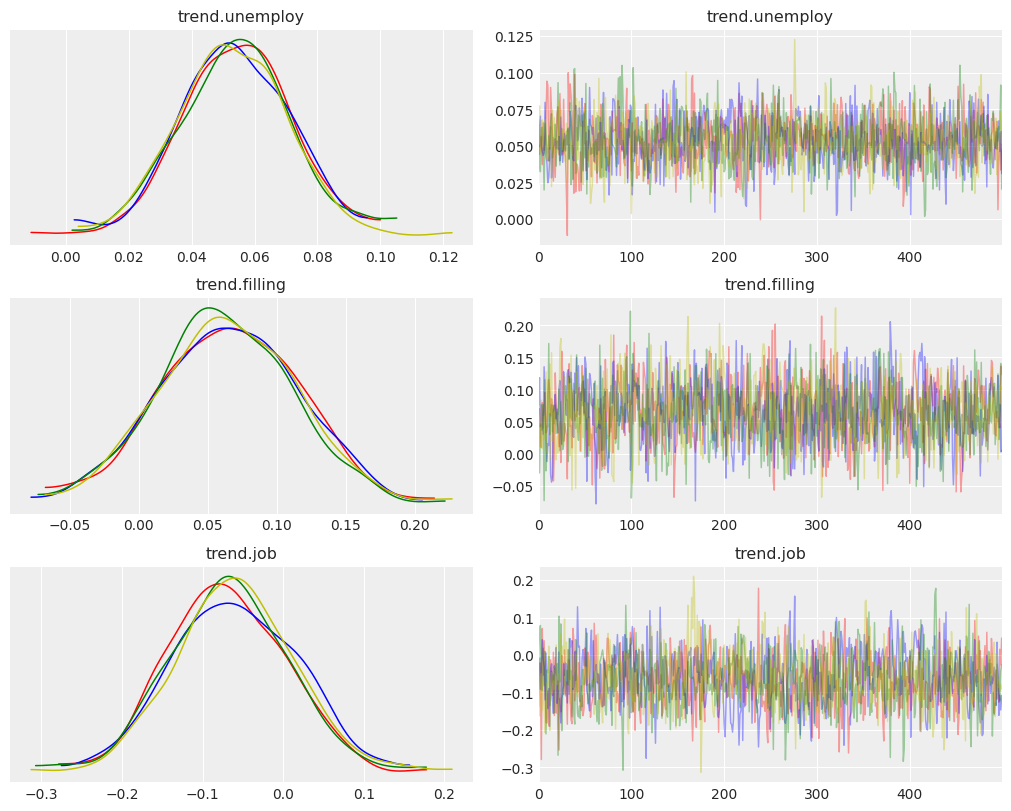

In [10]:
az.style.use('arviz-darkgrid')
az.plot_trace(
    ps, 
    var_names=['trend.unemploy', 'trend.filling', 'trend.job'],
    chain_prop={"color": ['r', 'b', 'g', 'y']},
    figsize=(10, 8),
);

Note that this is only applicable for `FullBayesianForecaster` using sampling method such as MCMC.

### Samples Density

We can also check the density of samples by pair plot.

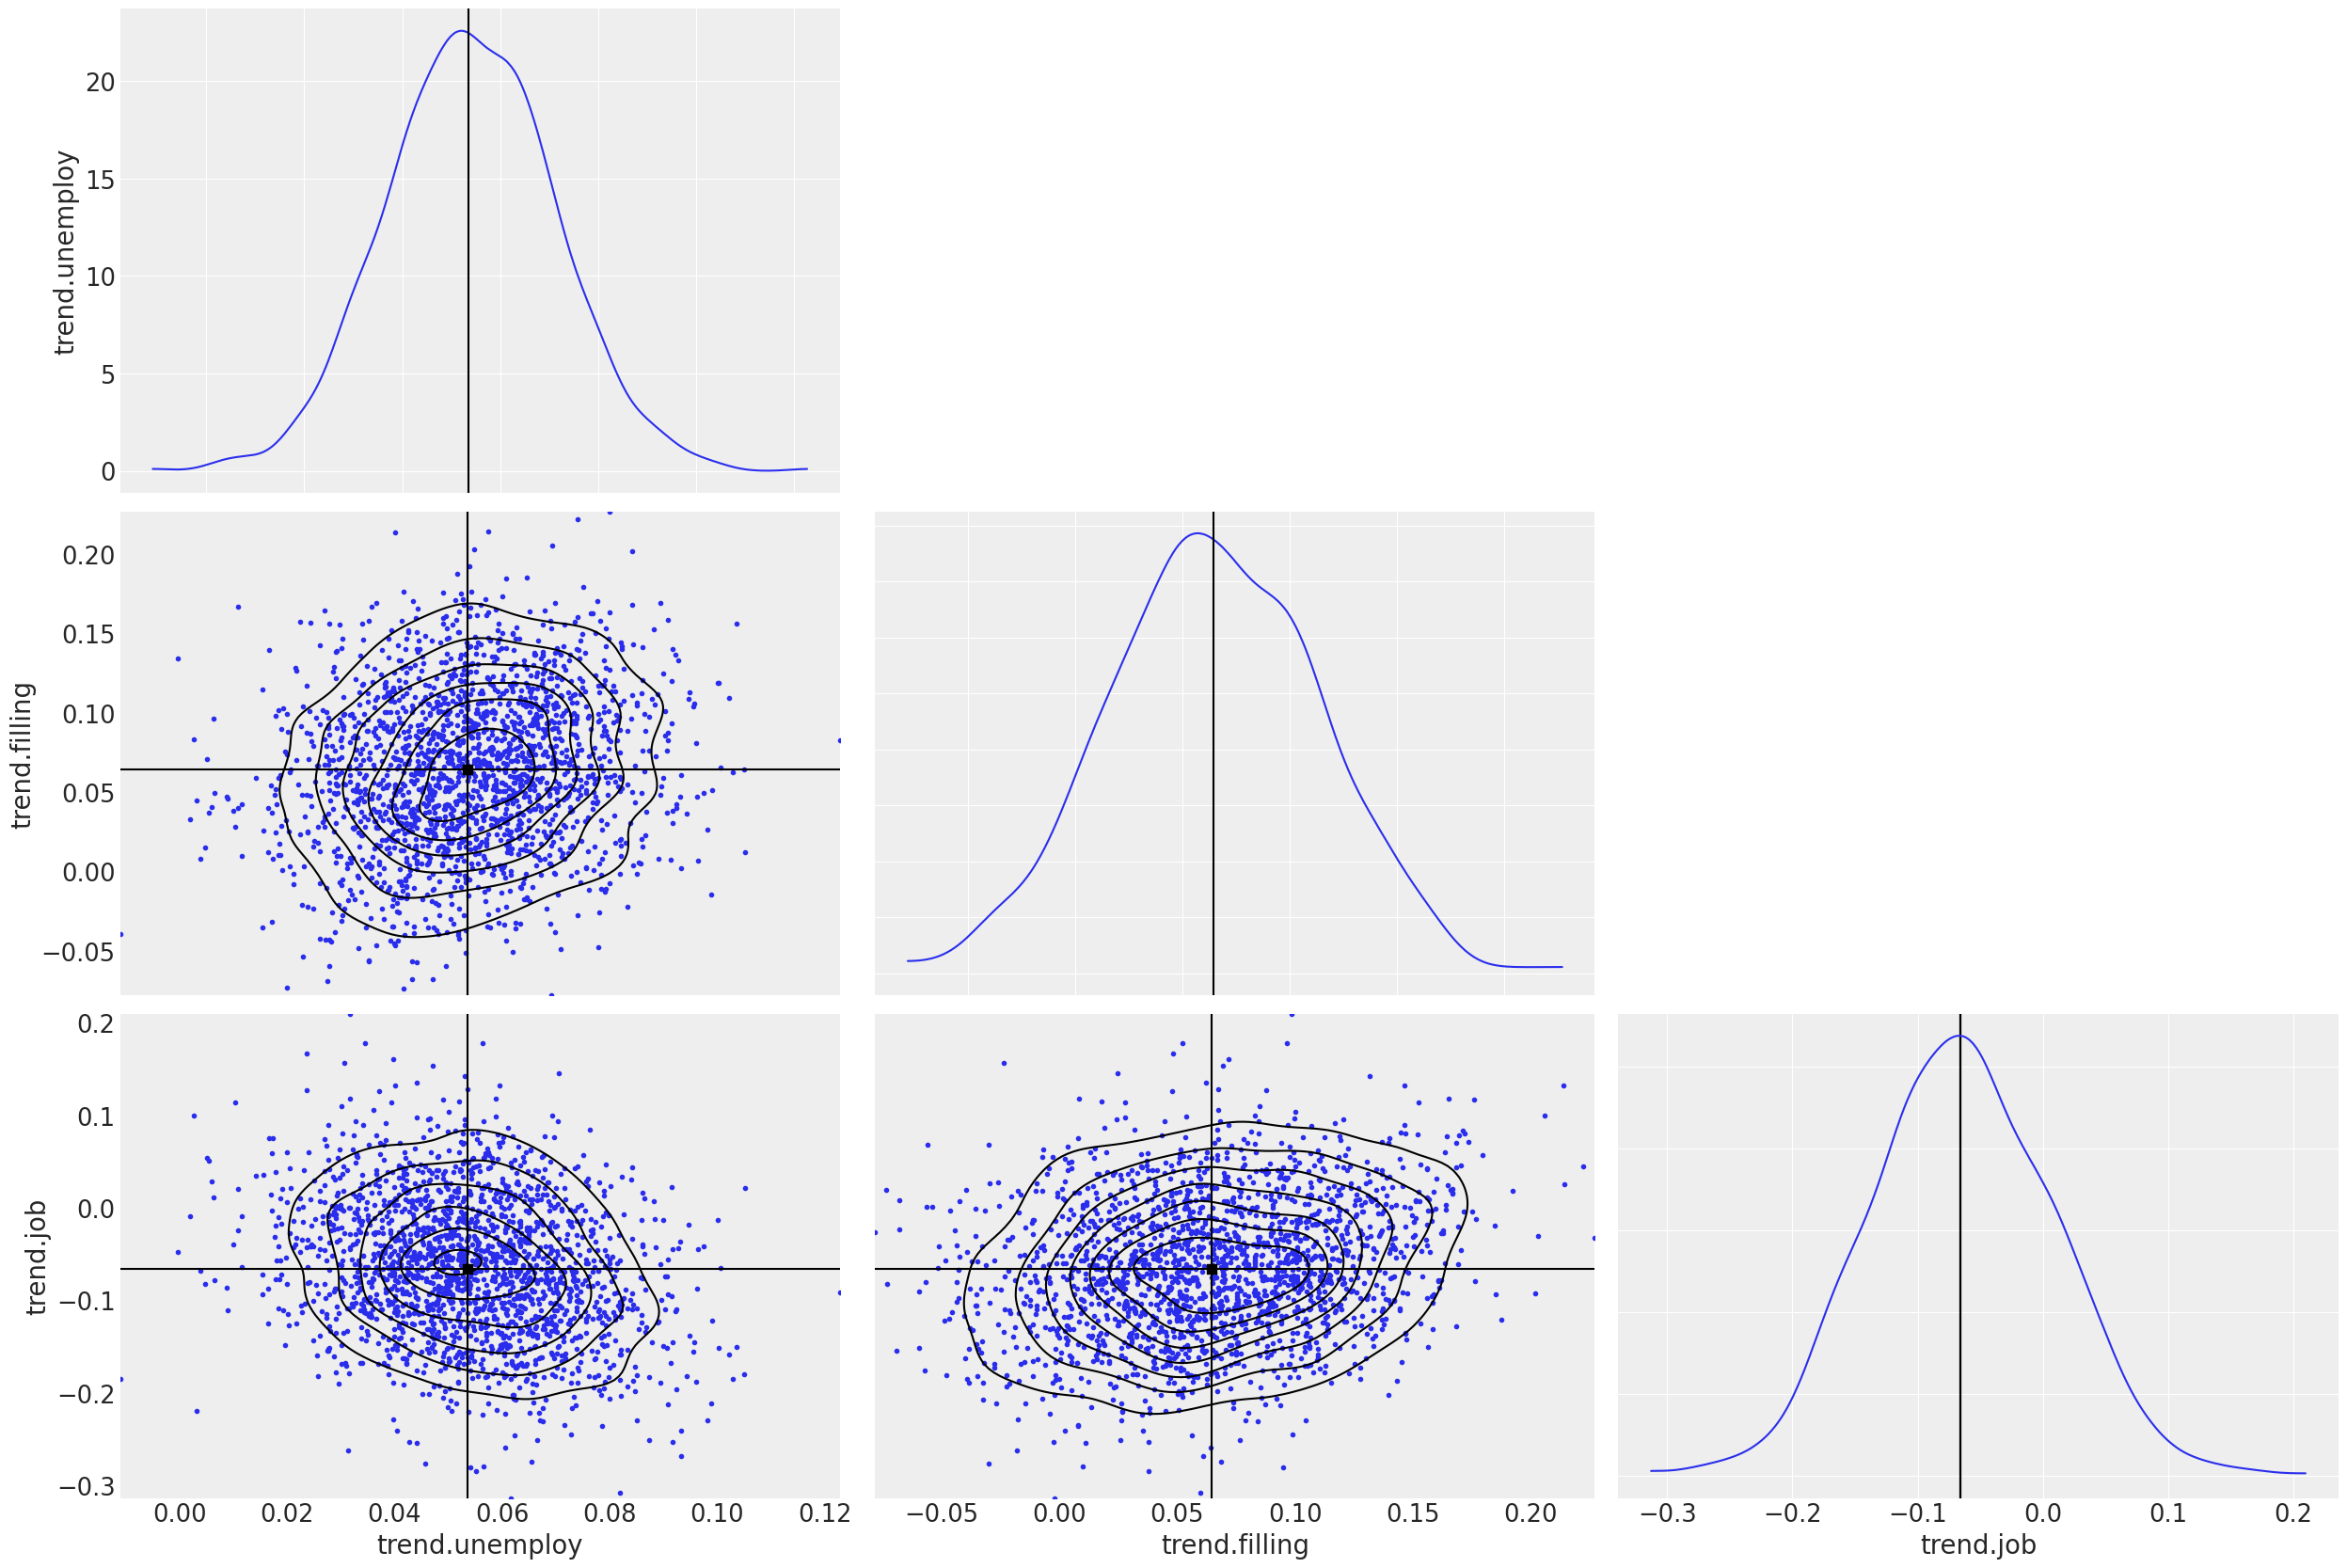

In [11]:
az.plot_pair(
    ps, 
    var_names=['trend.unemploy', 'trend.filling', 'trend.job'],
    kind=["scatter", "kde"],
    marginals=True,
    point_estimate="median",
    textsize=18.5,
);

### Compare Models

You can also compare posteriors across different models with the same parameters. You can use plots such as density plot and forest plot to do so.

In [12]:
dlt_smaller_prior = DLT(
    response_col=RESPONSE_COL,
    date_col=DATE_COL,
    regressor_col=REGRESSOR_COL,
    regressor_sigma_prior=[0.05, 0.05, 0.05],
    seasonality=52,
    num_warmup=2000,
    num_sample=2000,
    chains=4
)
dlt_smaller_prior.fit(df=df)
ps_smaller_prior = dlt_smaller_prior.get_posterior_samples(relabel=True, permute=False)

INFO:orbit:Sampling(PyStan) with chains:4, cores:8, temperature:1.0, warmups(per chain):500 and samples(per chain):500.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


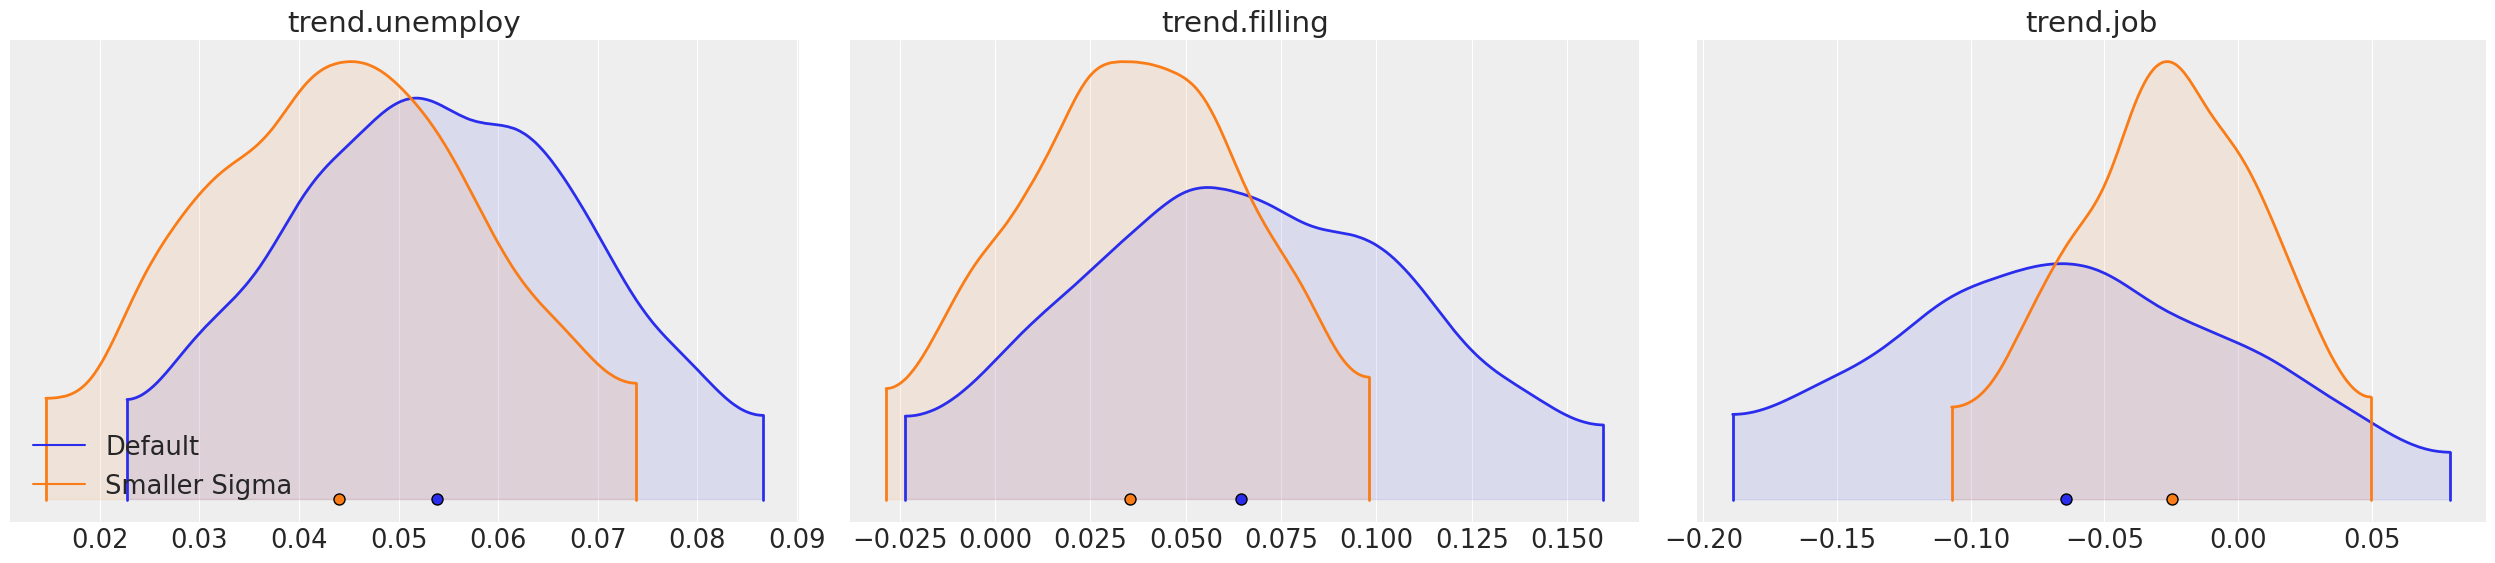

In [13]:
az.plot_density(
    [ps, ps_smaller_prior],
    var_names=['trend.unemploy', 'trend.filling', 'trend.job'],
    data_labels=["Default", "Smaller Sigma"],
    shade=0.1,
    textsize=18.5,
);

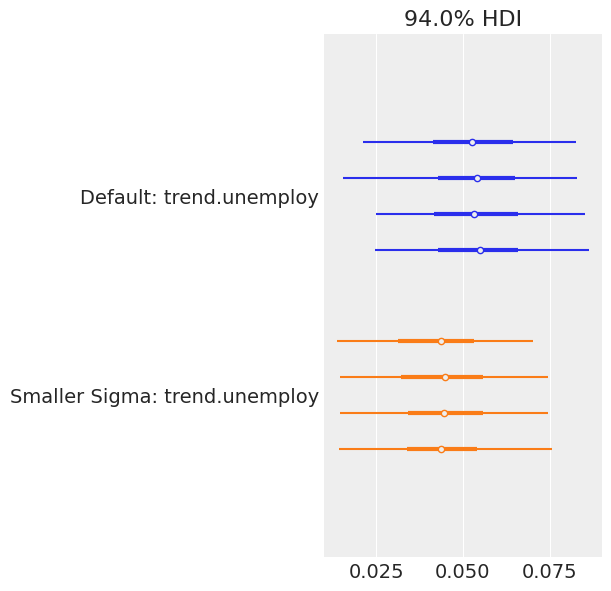

In [14]:
az.plot_forest(
    [ps, ps_smaller_prior],
    var_names=['trend.unemploy'],
    model_names=["Default", "Smaller Sigma"],
);

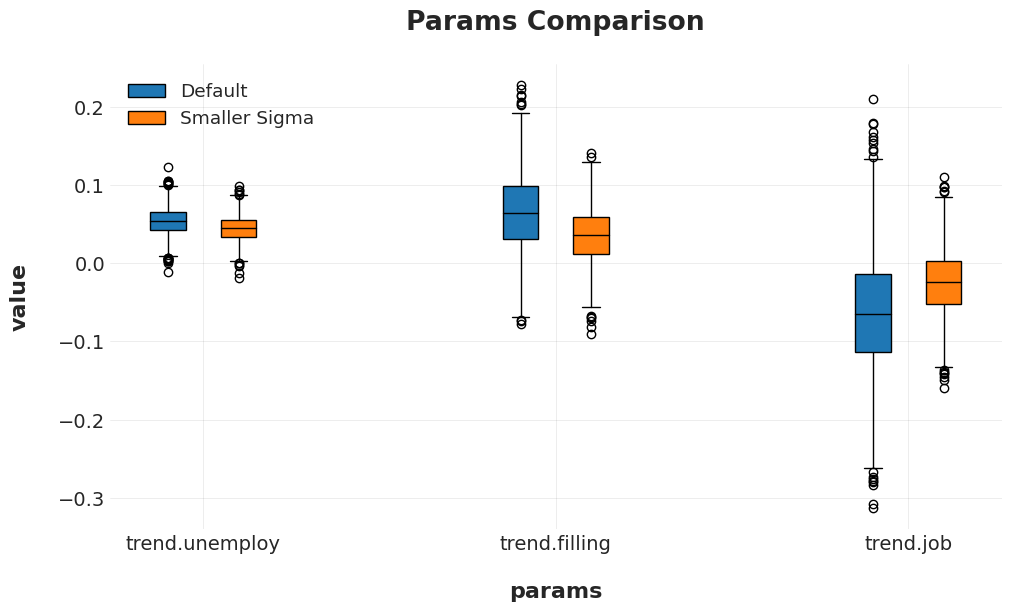

In [15]:
params_comparison_boxplot(
        ['Default', 'Smaller Sigma'], 
        [np.stack([ps['trend.unemploy'].flatten(), ps['trend.filling'].flatten(), ps['trend.job'].flatten()]).transpose(), 
         np.stack([ps_smaller_prior['trend.unemploy'].flatten(), ps_smaller_prior['trend.filling'].flatten(), ps_smaller_prior['trend.job'].flatten()]).transpose()], 
        ['trend.unemploy', 'trend.filling', 'trend.job'], 
        box_width = .1, box_distance=0.1, 
        showfliers=True
);

## Conclusion

Orbit models allow multiple visualization to diagnostics models and compare different models. We briefly introduce some basic syntax and usage of `arviz`. There is an [example gallery](https://arviz-devs.github.io/arviz/examples/index.html) built by the original team. Users can learn the details and more advance usage there. Meanwhile, the Orbit team aims to continue expand the scope to leverage more work done from the `arviz` project.